In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import binotools as bt

from astropy import units as u
import astropy.io.fits as fits
import scipy
from lmfit.models import GaussianModel, SkewedGaussianModel

import os, datetime
import glob

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')
mpl.rcParams['font.size']  = 16
mpl.rcParams['figure.dpi'] = 150
import matplotlib.mathtext as mathtext
mathtext.FontConstantsBase.sup1 = 0.5
mathtext.FontConstantsBase.sub1 = 0.2
mathtext.FontConstantsBase.sub2 = 0.2

from palettable.tableau import Tableau_10
col = Tableau_10.hex_colors

# Flux limit

$$f_{lim} = N \times \frac{1}{1 - e^{-\frac{r^2}{2\sigma_{psf}^2}}} \sqrt{\frac{L}{\Delta \lambda}} \sigma_i \times \Delta \lambda$$

In [17]:
FWHM_psf  = 4.          # pixels (0.24"/pixel)
sigma_psf = FWHM_psf/2.355

def aperture_correct(r_ap, FWHM_psf=4.):
    sigma_psf = FWHM_psf/2.355
    return 1./(1. - np.exp(-0.5*(r_ap/sigma_psf)**2.))

def flux_lim(noise1D, dlambda_A, r_ap_pix, linewidth_A=10., FWHM_psf_pix=4., Nsig=5.):
    return Nsig * aperture_correct(r_ap_pix, FWHM_psf_pix) * np.sqrt(linewidth_A/dlambda_A) * dlambda_A * noise1D


def wave_to_redshift(wave, wave0=1216.):
    return wave/wave0 - 1.

# Get data

In [7]:
binodir = os.environ['BINO_DIR']+'2649_BLAS_1/'
slits = pd.read_csv(binodir+'masks/BLAS_1_slits.csv')

# datadir = os.environ['BINO_DIR']+'2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs_fluxcalib/'

# transmission_file = glob.glob(datadir+'*transmission.txt')[0]
# transmission      = np.genfromtxt(transmission_file, names=True)

In [23]:
obj2D_file        = datadir+'obj_abs_slits_lin_fluxcalib.fits'
obj2D_skysub_file = datadir+'obj-sky_slits_lin_fluxcalib.fits'

dat2D_files = [obj2D_file, obj2D_skysub_file]

In [27]:
datadir = os.environ['BINO_DIR']+'SAO-9/fluxcalib/'
dat2D_files = sorted(os.listdir(datadir))
print(dat2D_files)

['2019.0208_obj_abs_slits_lin_fluxcalib.fits', '2019.0212_obj_abs_slits_lin_fluxcalib.fits', '2019.0329_obj_abs_slits_lin_fluxcalib.fits', '2019.0331_obj_abs_slits_lin_fluxcalib.fits', '2019.0404_obj_abs_slits_lin_fluxcalib.fits']


# Get pri 3 slits (z>5 LBGs, mostly empty -- use to calculate flux limits)

In [8]:
slits['extnum'] = slits.index + 1

pri3_slits = slits[slits.priority == 3]
pri3_slits.reset_index(drop=True, inplace=True)

# Estimate typical Lya linewidth

In [12]:
bino_plot = bt.BinoPlotter(datadir+dat2D_files[1])#, transmission=transmission['transmission'])

c = 3.e5
linewidth_kms = 200.
linewidth_A   = bino_plot.waveA*linewidth_kms/c

print(linewidth_A)
print('Typical Lya linewidth = %.2f A' % np.median(linewidth_A))

[4.50666667 4.50708    4.50749333 ... 6.83332002 6.83373335 6.83414668]
Typical Lya linewidth = 5.67 A


# Estimate flux limit



## Sensitivity

#1F77B4


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


3.2526900909172875e-19
#FF7F0E
1.9048062974854763e-19
#2CA02C
1.1305879143882111e-19
#D62728
3.185182045905229e-19
#9467BD
3.1673798270829954e-19


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2559: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '


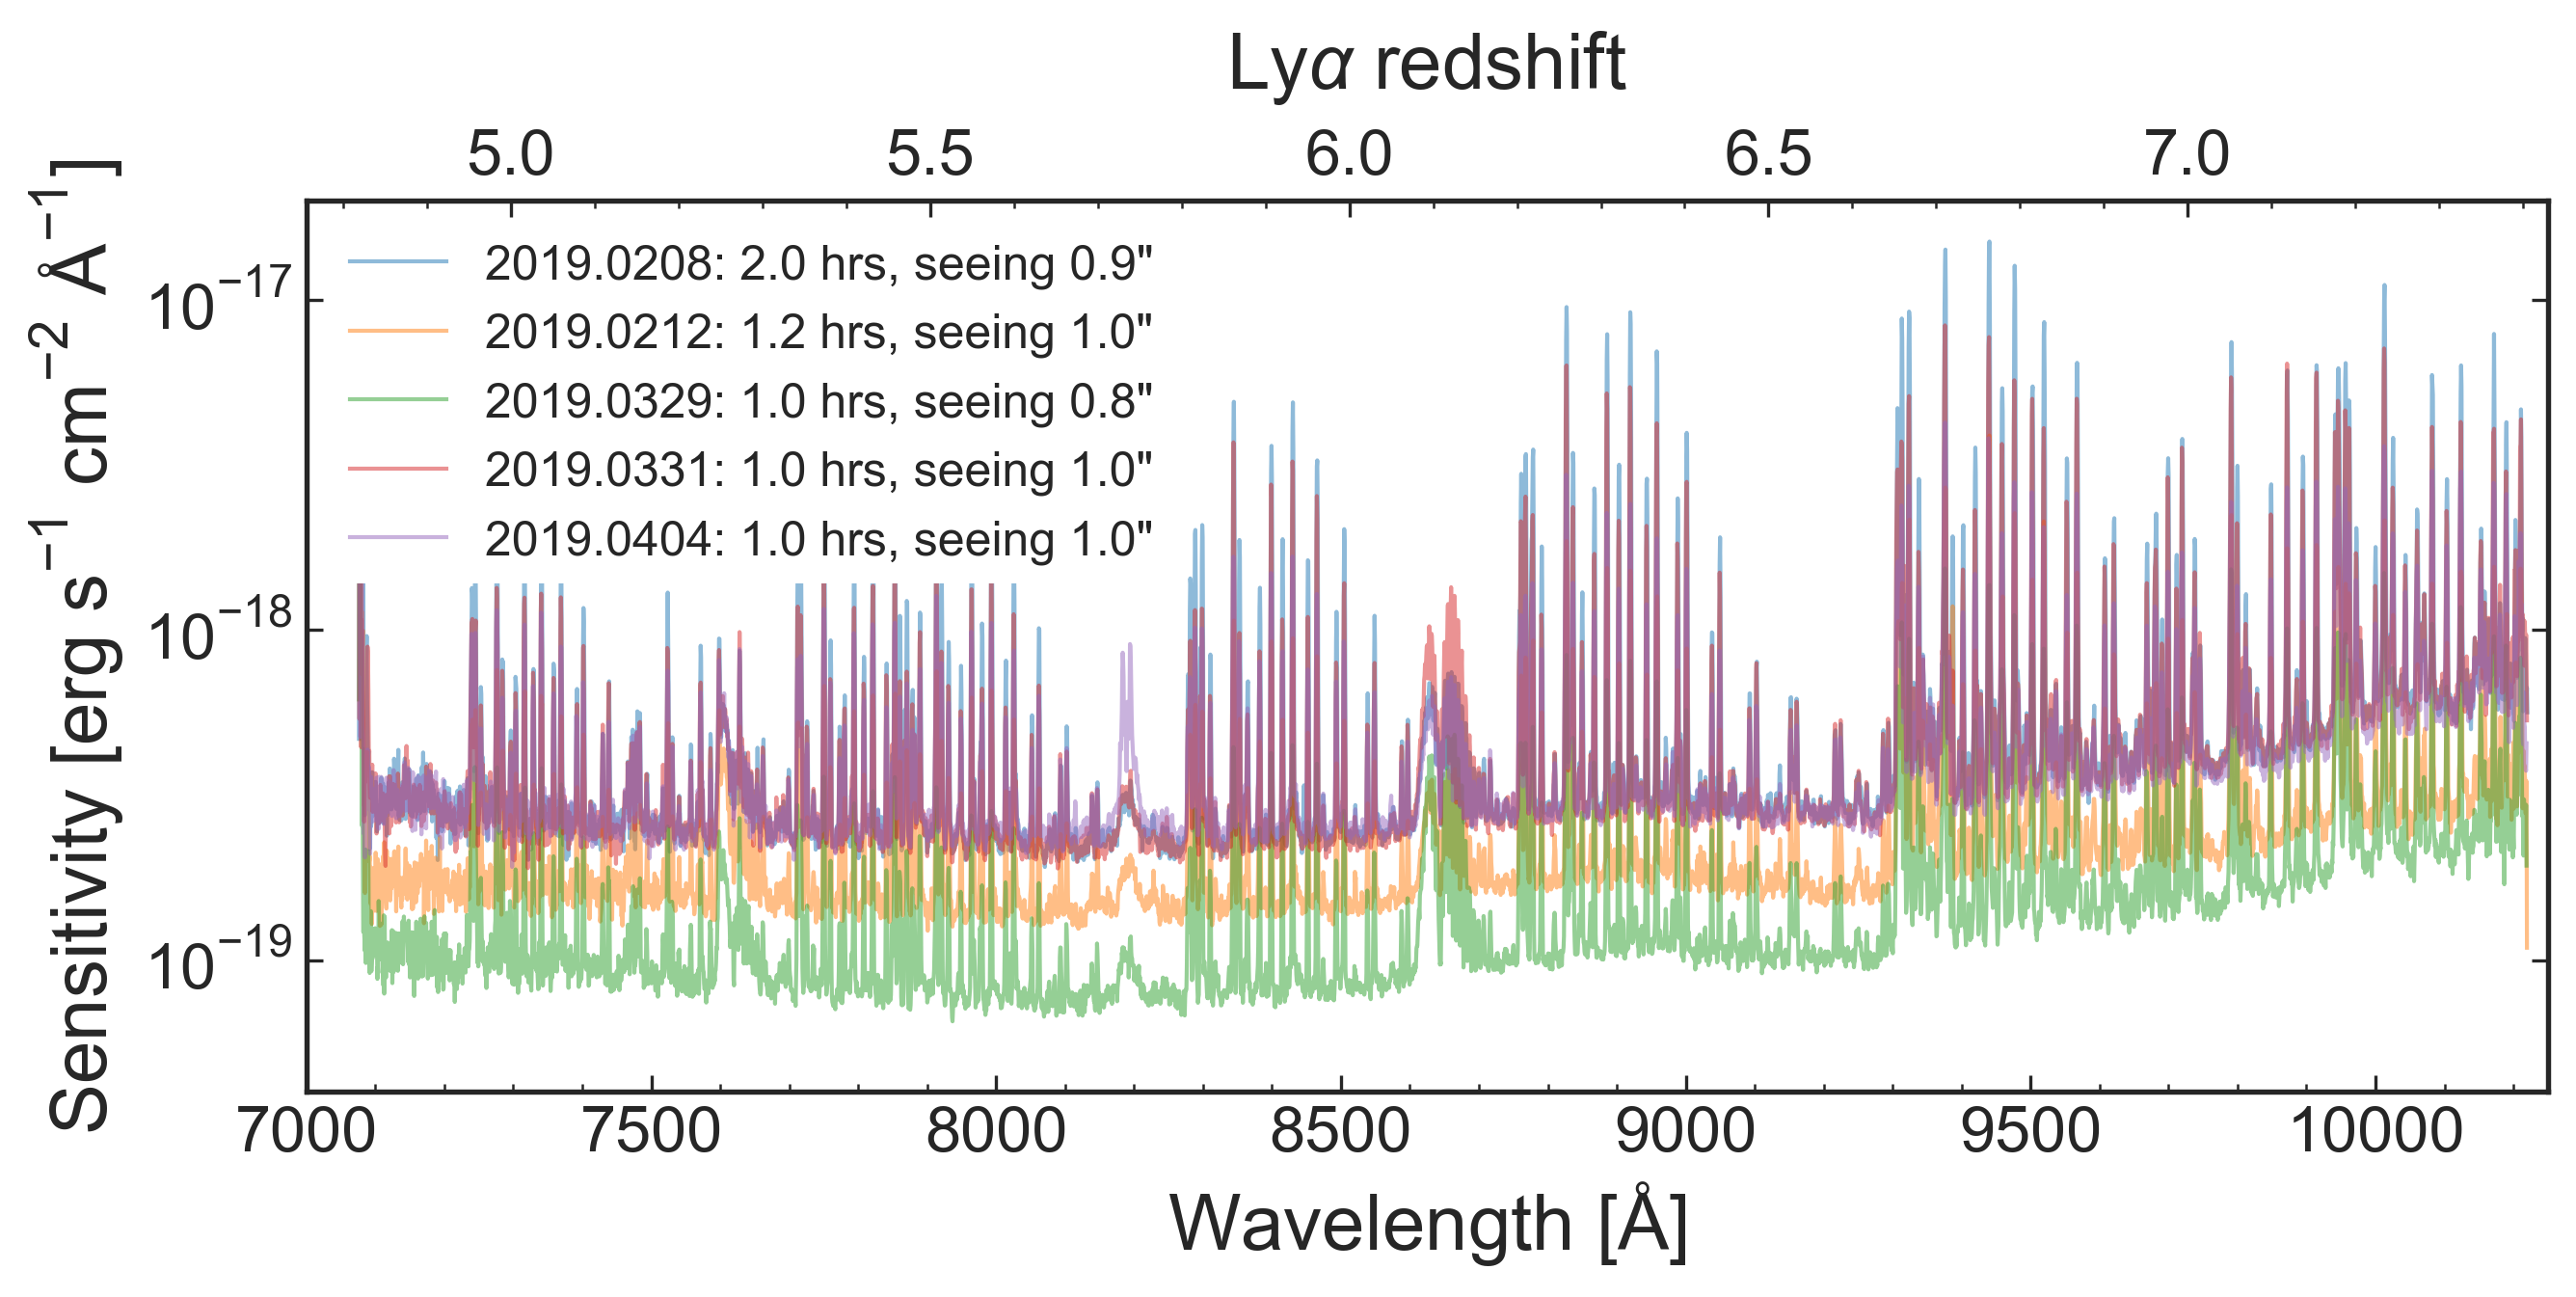

In [59]:
# cols = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=300)

for i, file in enumerate(dat2D_files):
    
    hdu_list = fits.open(datadir+file)
    header = hdu_list[0].header
    exp_time_hr = header['EXPTIME']/3600.

    color = col[i]
    
#     if i == 0:
#         ax.annotate('OBJ_ABS', xy=(0.01, 0.9), color=color, xycoords='axes fraction')
#     else:
#         ax.annotate('OBJ-SKY', xy=(0.01, 0.8), color=color, xycoords='axes fraction')
    
    # Extract star in 2 PSF aperture
    star_id = 19
    spec2D_star = hdu_list[star_id + 1].data * 1e-19
    psf  = np.nansum(spec2D_star, axis=1)
    psf /= psf.max()
    
    # Fit with Gaussian
    x = np.arange(len(psf))
    y = psf

    mod  = GaussianModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    PSF_FWHM = out.values['fwhm'] # pixels
    
    night = file.split('_')[0]
    label = '%s: %.1f hrs, seeing %.1f"' % (night, exp_time_hr, PSF_FWHM*0.24)
    
    noise1D = np.zeros((len(pri3_slits), len(bino_plot.waveA)))
    for j, slit in pri3_slits.iterrows():
            
        spec2D  = hdu_list[slit.targetnum].data
#         spec2D /= transmission['transmission']
            
        if 'abs' in file:
            spec2D *= 1e-19
        
        # Only use pixels within 0.2 < y < 0.8 of slit height
        slit_frac   = np.arange(spec2D.shape[0])/spec2D.shape[0]
        slit_center = np.where((slit_frac > 0.2) & (slit_frac < 0.8))[0]
                        
        # Take RMS of all pixels in slit at each wavelength to get noise per pixel
        noise1D[j] = np.nanstd(spec2D[slit_center,:], axis=0)
#         ax.semilogy(bino_plot.waveA, noise1D[j], lw=1, alpha=0.05, c=color)#, label=file.split('/')[-1].split('.fits')[0])
    
    ax.semilogy(bino_plot.waveA, np.nanmedian(noise1D, axis=0)*np.sqrt(exp_time_hr), lw=1, alpha=0.5, c=color, label=label)
    
    print(np.nanmedian(np.nanmedian(noise1D, axis=0)*np.sqrt(exp_time_hr)))
        
ax.legend(fontsize=12, frameon=True, framealpha=1)
ax.set_xlim(7000, 10250)
ax.set_ylim(4e-20, 2e-17)
ax_z = ax.twiny()

ax_z.plot(wave_to_redshift(bino_plot.waveA), noise1D[j], color='k', lw=0, ls='dashed')

ax_z.set_xlim(wave_to_redshift(np.array(ax.get_xlim())))

ax_z.set_xlabel(r'Ly$\alpha$ redshift', labelpad=10)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel(r'Sensitivity [erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$]')

plt.show()

## Flux limit

2019.0208: 5sigma flux limit for 6A line in 2.0 hrs = 8.87e-18
2019.0212: 5sigma flux limit for 6A line in 1.2 hrs = 5.20e-18
2019.0329: 5sigma flux limit for 6A line in 1.0 hrs = 3.08e-18
2019.0331: 5sigma flux limit for 6A line in 1.0 hrs = 8.69e-18
2019.0404: 5sigma flux limit for 6A line in 1.0 hrs = 8.64e-18
7.35239538680617e-18


(4.756578947368421, 7.429276315789474)

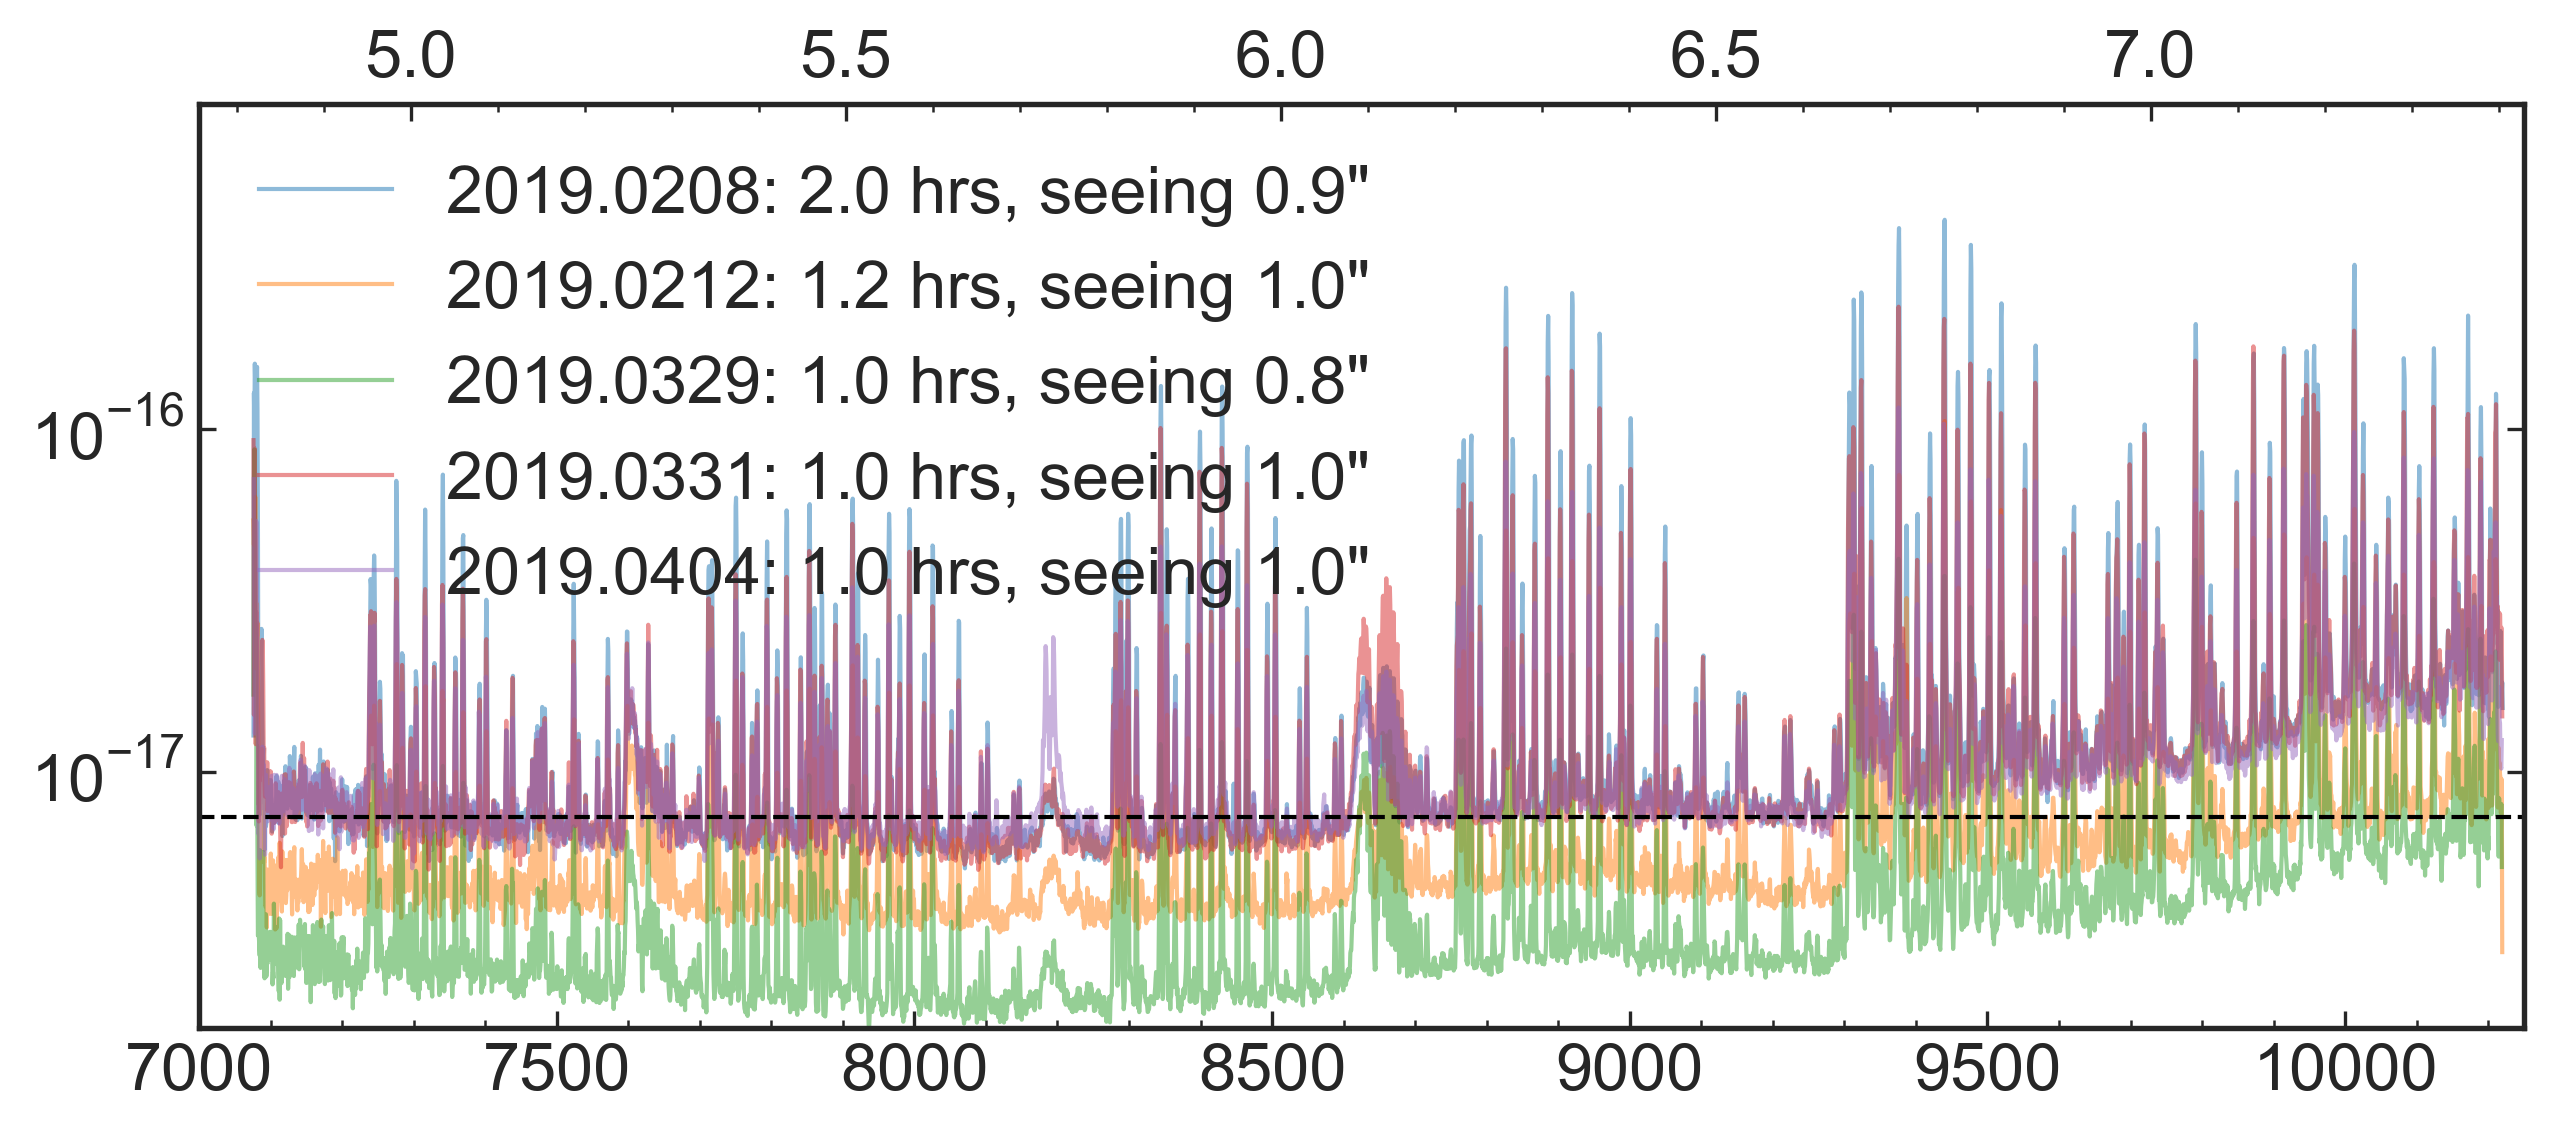

In [85]:
dlambda_A = np.median(np.gradient(bino_plot.waveA))

FWHM_psf   = 4 # pixels
Npix       = 2*FWHM_psf
linewidthA = 6. #A
Nsig       = 5.

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=300)

flim_med_all = np.zeros((len(dat2D_files), len(bino_plot.waveA)))
for i, file in enumerate(dat2D_files):
    
    hdu_list = fits.open(datadir+file)
    header = hdu_list[0].header
    exp_time_hr = header['EXPTIME']/3600.

    exp_time_hr = header['EXPTIME']/3600.

    color = col[i]
        
    # Extract star in 2 PSF aperture
    star_id = 19
    spec2D_star = hdu_list[star_id + 1].data * 1e-19
    psf  = np.nansum(spec2D_star, axis=1)
    psf /= psf.max()
    
    # Fit with Gaussian
    x = np.arange(len(psf))
    y = psf

    mod  = GaussianModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    PSF_FWHM = out.values['fwhm'] # pixels
    
    night = file.split('_')[0]
    label = '%s: %.1f hrs, seeing %.1f"' % (night, exp_time_hr, PSF_FWHM*0.24)
    
    noise1D = np.zeros((len(pri3_slits), len(bino_plot.waveA)))
    flim1D  = np.zeros((len(pri3_slits), len(bino_plot.waveA)))
    for j, slit in pri3_slits.iterrows():

        spec2D  = hdu_list[slit.targetnum].data
#         spec2D /= transmission['transmission']
            
        if 'abs' in file:
            spec2D *= 1e-19
        
        # Only use pixels within 0.2 < y < 0.8 of slit height
        slit_frac   = np.arange(spec2D.shape[0])/spec2D.shape[0]
        slit_center = np.where((slit_frac > 0.2) & (slit_frac < 0.8))[0]
                        
        # Take RMS of all pixels in slit at each wavelength to get noise per pixel
        noise1D[j] = np.nanstd(spec2D[slit_center,:], axis=0) * np.sqrt(exp_time_hr)

        # Flux limit, scale noise by sqrt(N) to get noise in spatial aperture
        flim1D[j] = flux_lim(np.sqrt(Npix)*noise1D[j], dlambda_A, 
                        r_ap_pix=Npix, linewidth_A=linewidthA,
                        FWHM_psf_pix=FWHM_psf, Nsig=Nsig)
    
    ax.semilogy(bino_plot.waveA, np.nanmedian(flim1D, axis=0), lw=1, alpha=0.5, c=color, label=label)
    flim_med_all[i] = np.nanmedian(flim1D, axis=0)
    print('%s: %.0fsigma flux limit for %.0fA line in %.1f hrs = %.2e' % (night, Nsig, linewidthA, exp_time_hr, np.nanmedian(np.nanmedian(flim1D, axis=0))))

# ax.annotate(r'FWHM $= %.0f\mathrm{\AA} \sim %.0f$ km/s' % (linewidthA, (c*linewidthA/8000.)), xy=(0.01, 0.9), xycoords='axes fraction')
flim_med = np.nanmedian(flim_med_all)
print(flim_med)

ax.axhline(flim_med, c='k', ls='dashed', lw=1)
ax.legend()
ax.set_ylim(0.2*np.nanmedian(med_flim), 100*np.nanmax(med_flim))
ax.set_xlim(7000, 10250)

ax_z = ax.twiny()

ax_z.plot(wave_to_redshift(bino_plot.waveA), flim, color='k', lw=0, ls='dashed')

ax_z.set_xlim(wave_to_redshift(np.array(ax.get_xlim())))

# ax_z.set_xlabel(r'Ly$\alpha$ redshift', labelpad=10)
# ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
# ax.set_ylabel(r'$%.0f\sigma$ flux limit [erg s$^{-1}$ cm$^{-2}$]' % Nsig)

/Users/cmason/Documents/Research/Observing/CfA/Binospec/2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs_fluxcalib/obj_abs_slits_lin_fluxcalib.fits


No handles with labels found to put in legend.


5sigma flux limit for 6A line = 4.08e-18


Text(0, 0.5, '$5\\sigma$ flux limit [erg s$^{-1}$ cm$^{-2}$]')

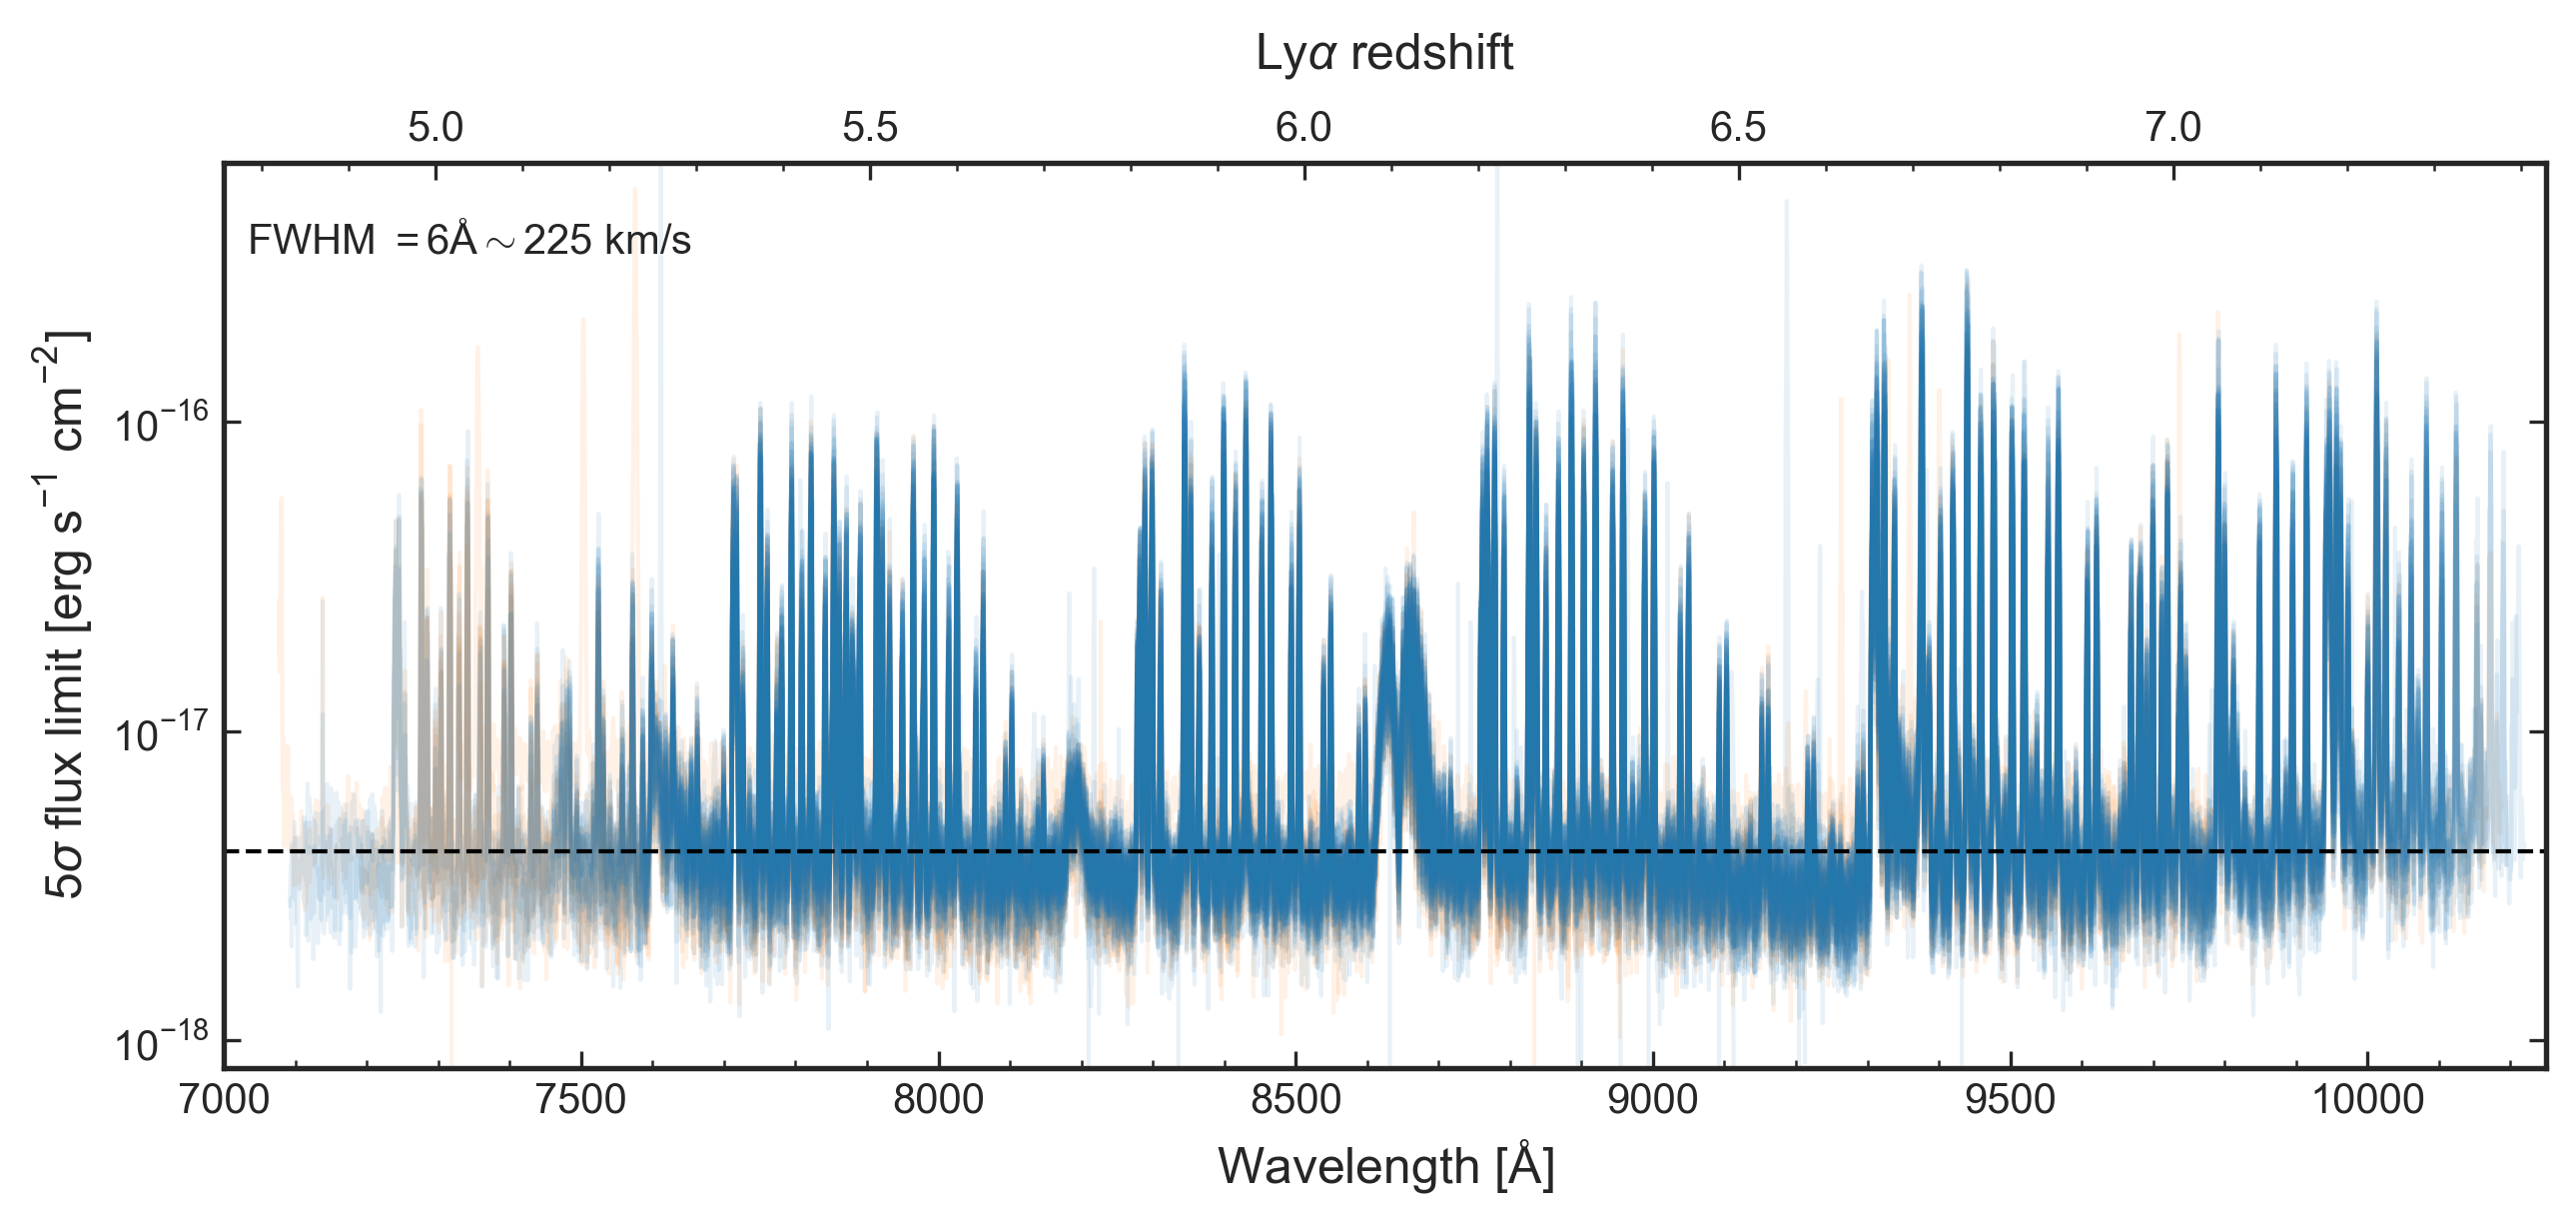

In [14]:
skysub = False

if skysub:
    file_list = [obj2D_skysub_file]
else:
    file_list = [obj2D_file]
    
bino_plot = bt.BinoPlotter(dat2D_files[1], transmission=transmission['transmission'])
dlambda_A = np.median(np.gradient(bino_plot.waveA))

FWHM_psf   = 4 # pixels
Npix       = 2*FWHM_psf
linewidthA = 6. #A
Nsig       = 5.

def wave_to_redshift(wave, wave0=1216.):
    return wave/wave0 - 1.

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=300)
med_flim = []
for file in file_list:
    print(file)
    hdu_list = fits.open(file)
    
    for i, slit in pri3_slits.iterrows():

        spec2D  = hdu_list[slit.targetnum].data
        spec2D /= transmission['transmission']

        if slit.side == 'A':
            col = 'tab:orange'
        else:
            col = 'tab:blue'
            
        if 'abs' in file:
            spec2D *= 1e-19
        
        # Only use pixels within 0.2 < y < 0.8 of slit height
        slit_frac   = np.arange(spec2D.shape[0])/spec2D.shape[0]
        slit_center = np.where((slit_frac > 0.2) & (slit_frac < 0.8))[0]
                        
        # Take RMS of all pixels in slit at each wavelength to get noise per pixel
        noise1D = np.nanstd(spec2D[slit_center,:], axis=0)

        # Flux limit, scale noise by sqrt(N) to get noise in spatial aperture
        flim = flux_lim(np.sqrt(Npix)*noise1D, dlambda_A, 
                        r_ap_pix=Npix, linewidth_A=linewidthA,
                        FWHM_psf_pix=FWHM_psf, Nsig=Nsig)

        ax.semilogy(bino_plot.waveA, flim, lw=1, c=col, alpha=0.1)#, label=file.split('/')[-1].split('.fits')[0])
        med_flim.append(np.nanmedian(flim))
    
med_flim = np.array(med_flim)
print('%.0fsigma flux limit for %.0fA line = %.2e' % (Nsig, linewidthA, np.nanmedian(med_flim)))

ax.annotate('FWHM $= %.0f\mathrm{\AA} \sim %.0f$ km/s' % (linewidthA, (c*linewidthA/8000.)), xy=(0.01, 0.9), xycoords='axes fraction')
ax.axhline(np.nanmedian(med_flim), c='k', ls='dashed', lw=1)
ax.legend()
ax.set_ylim(0.2*np.nanmedian(med_flim), 100*np.nanmax(med_flim))
ax.set_xlim(7000, 10250)

ax_z = ax.twiny()

ax_z.plot(wave_to_redshift(bino_plot.waveA), flim, color='k', lw=0, ls='dashed')

ax_z.set_xlim(wave_to_redshift(np.array(ax.get_xlim())))

ax_z.set_xlabel(r'Ly$\alpha$ redshift', labelpad=10)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('$%.0f\sigma$ flux limit [erg s$^{-1}$ cm$^{-2}$]' % Nsig)

## Distribution of median flux limits

Text(0, 0.5, 'PDF')

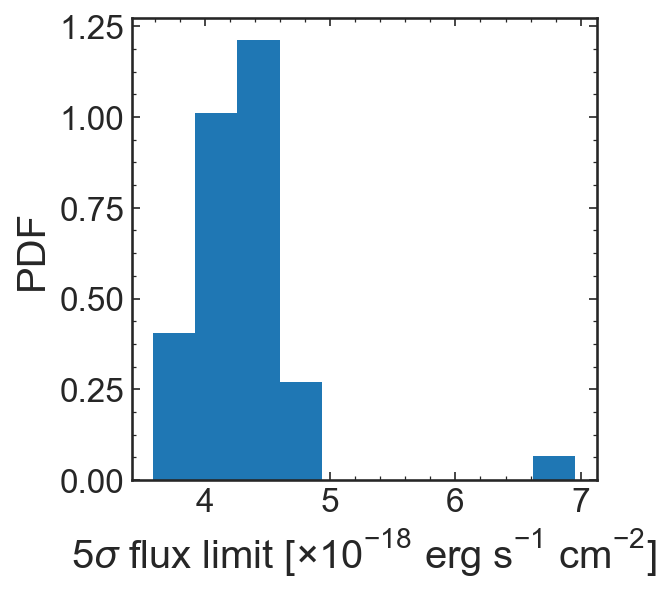

In [220]:
plt.figure(figsize=(4,4))
plt.hist(med_flim*1e18, density=True)
plt.xlabel(r'$%.0f\sigma$ flux limit [$\times10^{-18}$ erg s$^{-1}$ cm$^{-2}$]' % Nsig)
plt.ylabel('PDF')

## Does it vary with position on mask?

Text(0.5, 0, 'Slit number')

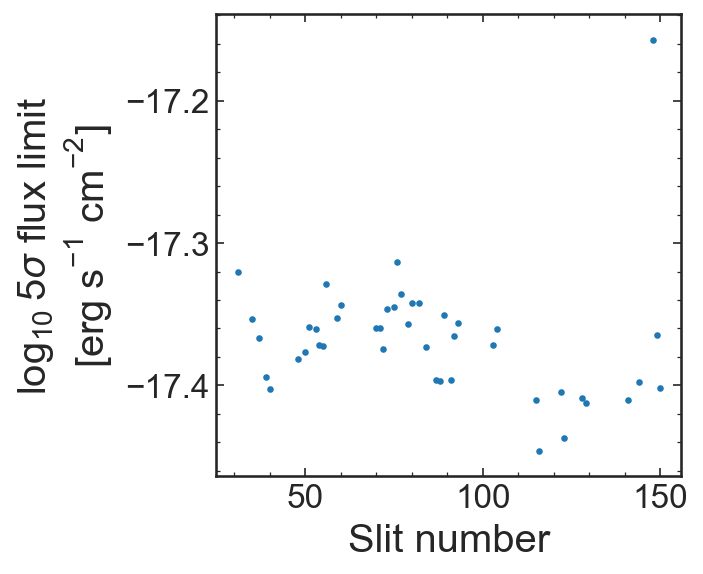

In [235]:
plt.figure(figsize=(4,4))
plt.scatter(pri3_slits.targetnum, np.log10(np.array(med_flim)), s=10)
plt.ylabel(r'$\log_{10} \: %.0f\sigma$ flux limit'% Nsig+'\n[erg s$^{-1}$ cm$^{-2}$]' )
plt.xlabel('Slit number')

## RMS flux as function of spatial position on slit

Does it vary significantly across slit?

Text(0, 0.5, 'RMS flux')

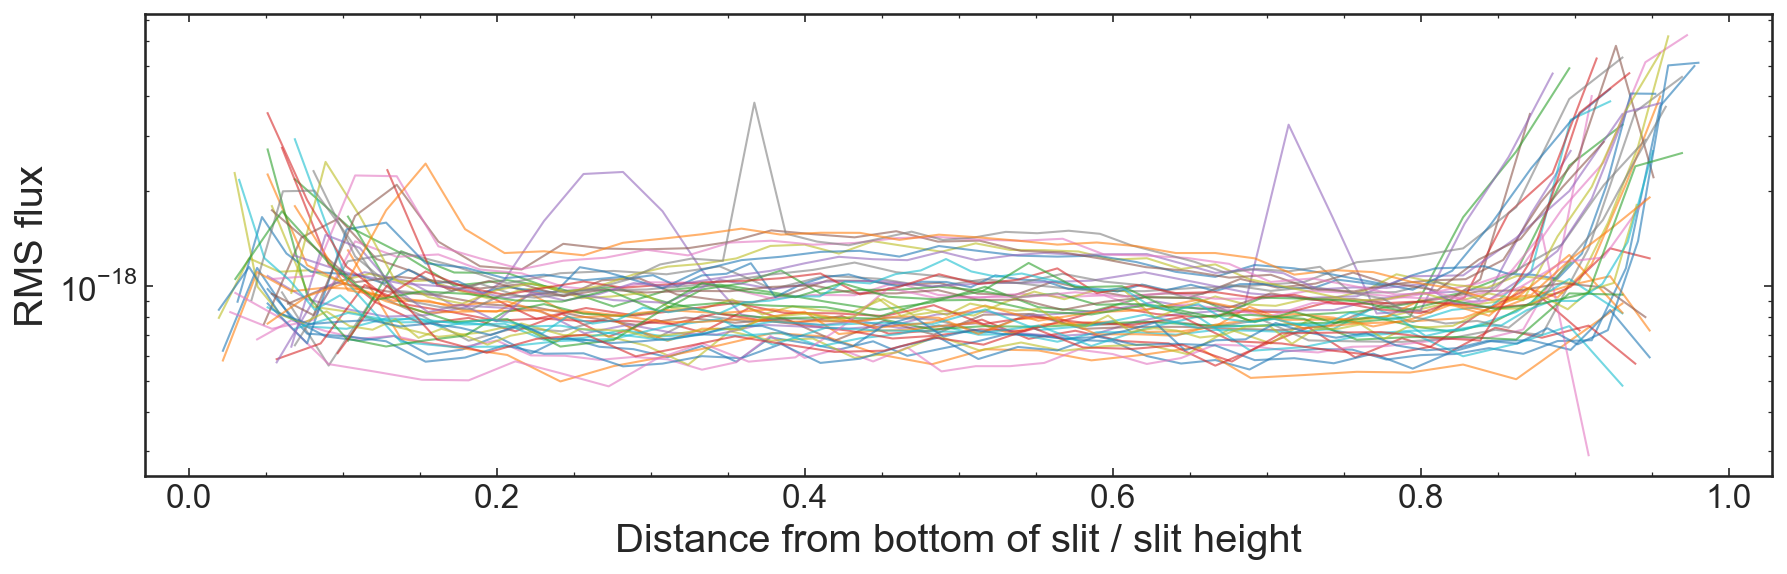

In [240]:
bino_plot = bt.BinoPlotter(file, transmission=transmission['transmission'])
dlambda_A = np.median(np.gradient(bino_plot.waveA))

Npix = 8.

fig, ax = plt.subplots(1,1, figsize=(14,4))

for file in [dat2D_files[1]]:

    hdu_list = fits.open(file)
    
    for i, slit in pri3_slits.iterrows():

        image  = hdu_list[slit.targetnum].data
        image /= transmission['transmission']

        if 'abs' in file:
            image *= 1e-19
        
        # RMS of all pixels across slit
        noise_spat1D = np.nanstd(image, axis=1)

        # Fraction of slit height
        slitheight_frac = (np.arange(image.shape[0]))/image.shape[0]
        
        ax.semilogy(slitheight_frac, noise_spat1D, lw=1, alpha=0.6)    

ax.set_xlabel('Distance from bottom of slit / slit height')
ax.set_ylabel('RMS flux')

# Compare with Daniel's estimate

Daniel's initial estimate: 1.4e-18 erg/s/cm^2 in 4 hours (16A line)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


5sigma flux limit in 1.00 hours = 1.40e-17


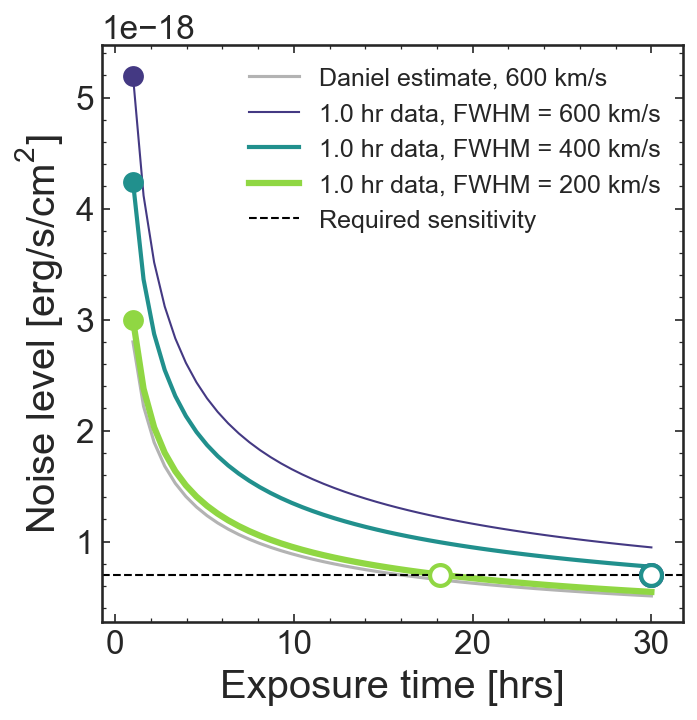

In [87]:
N0_Daniel = 1.4e-18
t_Daniel  = 4.
linewith_Daniel = 600 # km/s

# old data==============
t_now  = 6.25
N0_now = 1.41e-18

# single nights ==========
t_now  = 1.
N0_now = 3e-18
linewidth_now = 200.
#=================

StoN  = 5.

# Want
noise_req = 7.e-19 # from proposal - to get sufficient LAEs

t = np.linspace(1, 30.)
def N_t(t, N0=N0_Daniel, t0=t_Daniel):
    return N0*np.sqrt(t0)/np.sqrt(t)
  
FWHM_tab = np.array([600., 400., 200.])
cmap = mpl.cm.get_cmap('viridis_r')
norm = mpl.colors.Normalize(vmin=FWHM_tab.min()-100, vmax=FWHM_tab.max()+100)

plt.figure(figsize=(5,5))
plt.plot(t, N_t(t), c='0.7', lw=1.5, label='Daniel estimate, %.0f km/s' % linewith_Daniel)
for FWHM in FWHM_tab:
    
    sensitivity = np.sqrt(FWHM/linewidth_now)*N_t(t, N0=N0_now, t0=t_now)
    
    plt.plot(t, sensitivity, c=cmap(norm(FWHM)), lw=(800-FWHM)/200, label='%.1f hr data, FWHM = %.0f km/s' % (t_now, FWHM))
    
    # Current sensitivity
    plt.scatter(t_now, np.sqrt(FWHM/linewidth_now)*N_t(t_now, N0=N0_now, t0=t_now),
                c=cmap(norm(FWHM)), s=100, zorder=10)
    
    # Time to reach required sensivity
    t_req = t[np.argmin(np.abs(sensitivity - noise_req))]
    plt.scatter(t_req, noise_req, edgecolors=cmap(norm(FWHM)), facecolor='w', lw=2, s=100, zorder=10)
    
plt.axhline(noise_req,  c='k', ls='dashed', lw=1, label='Required sensitivity')

plt.legend(fontsize=12)

plt.xlabel('Exposure time [hrs]')
plt.ylabel('Noise level [erg/s/cm$^2$]')

# We want S/N > 5
print('%.0fsigma flux limit in %.2f hours = %.2e' % (StoN, t_now, N_t(t_now) * StoN, ))